In [1]:
import warnings
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost as xgb
from scipy.stats import skew

np.warnings.filterwarnings('ignore', category=DeprecationWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

# set Jupyter to display ALL output from a cell (not just last output)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

# set pandas and numpy options to make print format nicer
pd.set_option("display.width",100)
pd.set_option("display.max_columns",1000)
pd.set_option('display.max_colwidth', 80)
pd.set_option('display.max_rows', 500)
np.set_printoptions(linewidth=120, threshold=5000, edgeitems=10, suppress=True)

## Define utility functions

In [2]:
# function to add additional variables to train and test
def add_derived(data):       
    # create derived values to help with modelling
    data["zTotalHouse"] = data["Total_Bsmt_SF"] + data["First_Flr_SF"] + data["Second_Flr_SF"]   
    data["zTotalArea"]  = data["Total_Bsmt_SF"] + data["First_Flr_SF"] + data["Second_Flr_SF"] + data["Garage_Area"]
    data["zTotalHouse_OverallQual"] = data["zTotalHouse"] * data["oOverall_Qual"]
    data["zGrLivArea_OverallQual"] = data["Gr_Liv_Area"] * data["oOverall_Qual"]
    data["zoMSZoning_TotalHouse"] = data["oMS_Zoning"] * data["zTotalHouse"]
    data["zMSZoning_OverallQual"] = data["oMS_Zoning"] + data["oOverall_Qual"]
    data["zMSZoning_YearBuilt"] = data["oMS_Zoning"] + data["Year_Built"]
    data["zNeighborhood_TotalHouse"] = data["oNeighborhood"] * data["zTotalHouse"]
    data["zNeighborhood_OverallQual"] = data["oNeighborhood"] + data["oOverall_Qual"]
    data["zNeighborhood_YearBuilt"] = data["oNeighborhood"] + data["Year_Built"]
    data["zBsmtFinSF1_OverallQual"] = data["BsmtFin_SF_1"] * data["oOverall_Qual"]
    data["zFunctional_TotalHouse"] = data["oFunctional"] * data["zTotalHouse"]
    data["zFunctional_OverallQual"] = data["oFunctional"] + data["oOverall_Qual"]
    data["zLotArea_OverallQual"] = data["Lot_Area"] * data["oOverall_Qual"]
    data["zTotalHouse_LotArea"] = data["zTotalHouse"] + data["Lot_Area"]
    data["zCondition1_TotalHouse"] = data["oCondition_1"] * data["zTotalHouse"]
    data["zCondition1_OverallQual"] = data["oCondition_1"] + data["oOverall_Qual"]
    data["zBsmt"] = data["BsmtFin_SF_1"] + data["BsmtFin_SF_2"] + data["Bsmt_Unf_SF"]
    data["zRooms"] = data["Full_Bath"]+data["TotRms_AbvGrd"]
    data["zPorchArea"] = data["Open_Porch_SF"]+data["Enclosed_Porch"]+data["Three_season_porch"]+data["Screen_Porch"]
    data["zTotalPlace"] =data["Total_Bsmt_SF"]+data["First_Flr_SF"]+data["Second_Flr_SF"] + data["Garage_Area"] + \
                         data["Open_Porch_SF"]+data["Enclosed_Porch"]+data["Three_season_porch"]+data["Screen_Porch"] 
    return data

def rmse(predictions, actuals):
    return np.sqrt(np.mean( (predictions - actuals)**2 ))

#function to process the test and train datasets to prepare for modeling
def process(trainO, testO):
    train = trainO.copy()
    train = train.drop(['PID','Utilities','Condition_2',], axis=1)
    train['Sale_Price'] = np.log1p(train.Sale_Price)
    train.loc[train.Garage_Yr_Blt.isnull(),"Garage_Yr_Blt"] = train.Year_Built
    should_be_categoricals = ['Bsmt_Full_Bath','Bsmt_Half_Bath','Full_Bath','Half_Bath','Bedroom_AbvGr',
                              'Kitchen_AbvGr','TotRms_AbvGrd','Fireplaces','Garage_Cars']
    for col in should_be_categoricals:
        train[col] = train[col].astype(str)
        
#     create lookup table to add new columns with mean sale price of categorical column
    tables = []
    for col in train.select_dtypes(include=["object"]).columns:
        lookup = train.groupby([col])[['Sale_Price']].agg(['mean']).add_suffix("_val").reset_index()
        lookup.columns = ['value', 'number']
        lookup['column'] = col
        tables.append(lookup)
    lookup = pd.concat(tables)
        
    for col in train.select_dtypes(include=["object"]).columns: # create new columns with mean of sale price
        train['o'+col] = train[col].map(lookup[lookup.column==col].set_index('value')['number'])
        
#     consolidate rare values into one dummy value on train dataset
    for col in train.select_dtypes(include=["object"]).columns:
        variables = train[col].value_counts()
        for i, v in zip(variables.index, variables.values):
            if int(v) < 4:
                train.loc[train[col]==i, col] = 'xxxx'

#     get skewed columns from train data and apply log to each
    numerics = train.select_dtypes(exclude=["object"])
    skewness = numerics.apply(lambda x: skew(x))
    skewed_cols = skewness[abs(skewness) >= 5].index # affects 5 columns
    skewed_cols = skewed_cols[skewed_cols!='Sale_Price']
    train.loc[:, skewed_cols] = np.log1p(train[skewed_cols])

    train = add_derived(train)     # apply transformations to train datafram
    train = pd.get_dummies(train) # create dataframe with dummy variables replacing categoricals

    train = train.reindex(sorted(train.columns), axis=1) # sort columns to be in same sequence at train

    # split into X and y for train
    y_train = train.loc[:, 'Sale_Price']
    train = train.drop(['Sale_Price'], axis=1)

    #  test.csv  apply same transformations as for train dataset
    test = testO.copy()
    test = test.drop(['PID','Utilities','Condition_2'], axis=1)
    test.loc[test.Garage_Yr_Blt.isnull(),"Garage_Yr_Blt"] = test.Year_Built
    for col in should_be_categoricals:
        test[col] = test[col].astype(str)
    
    for col in test.select_dtypes(include=["object"]).columns:
        test['o'+col] = test[col].map(lookup[lookup.column==col].set_index('value')['number'])
    
    test[skewed_cols] = np.log1p(test[skewed_cols]) # apply log1p to skewed columns as per train
    test = add_derived(test) # apply transformations to test dataframe

#     loop through each test column and replace any values that arent in train with the most common train value
    for col in testO.select_dtypes(include=["object"]).columns:
        testO.loc[testO[~testO[col].isin(trainO[col].unique())].index, col] = 'xxxx'

    test = pd.get_dummies(test) # create dataframe with dummy variables replacing categoricals

    all_columns = train.columns.union(test.columns) # add columns to test that are in train but not test
    test = test.reindex(columns=all_columns).fillna(0)
    test = test.reindex(sorted(train.columns), axis=1) # sort columns to be in same sequence at train
    
    # Add first X principal components 
    pca = PCA(n_components=5) # was 5
    train = np.concatenate([train, pca.fit_transform(train) ], axis=1)
    test  = np.concatenate([test, pca.transform(test)], axis=1)
#     print('Test  dataset dimensions (original and processed)', testO.shape, test.shape,'\n')
    
    return train, y_train, test

def process_lr(trainO, testO):     
    # Create most basic X_train dataset, just for simple Linear Regression Model
    train_lr = trainO.copy()
    train_lr.loc[train_lr.Garage_Yr_Blt.isnull(),"Garage_Yr_Blt"] = train_lr.Year_Built 
    train_lr['Sale_Price'] = np.log1p(train_lr.Sale_Price)
    train_lr = pd.get_dummies(train_lr)
    train_lr = train_lr.reindex(sorted(train_lr.columns), axis=1)
    
    test_lr = testO.copy()
    test_lr.loc[test_lr.Garage_Yr_Blt.isnull(),"Garage_Yr_Blt"] = test_lr.Year_Built
    test_lr['Sale_Price'] = np.log1p(test_lr.Sale_Price)
    test_lr = pd.get_dummies(test_lr)
    
    all_columns = train_lr.columns.union(test_lr.columns) # add columns to test that are in train but not test
    test_lr = test_lr.reindex(columns=all_columns).fillna(0)
    test_lr = test_lr.reindex(sorted(train_lr.columns), axis=1) # sort columns to be in same sequence at train
    
    X_train_lr = train_lr.loc[:, train_lr.columns != 'Sale_Price']
    y_train_lr = train_lr.loc[:, 'Sale_Price']
    
#     print('Linear Regression Basic dataset dimensions (original and processed)', 
#           X_train_lr.shape, y_train_lr.shape, X_test_lr.shape, y_test_lr.shape)
    return X_train_lr, y_train_lr, test_lr

## Check performance on supplied data splits, calc chance of bonus marks

In [8]:
ames = pd.read_csv('Ames_data.csv')
ids = pd.read_csv('Project1_test_id.txt', sep=' ', header=None)

col=0
train  = ames.loc[~ames.PID.isin(ids[col]),:]
test   = ames.loc[ ames.PID.isin(ids[col]), ames.columns != 'Sale_Price']
y_test = ames.loc[ ames.PID.isin(ids[col]), ['PID','Sale_Price']]

# create test and train text files
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

In [4]:
# %%time
seed = 42
np.random.seed(seed)

models = [
#     LinearRegression(),
#     RandomForestRegressor(n_estimators=200, max_features='auto', max_depth=20, n_jobs=-1, random_state=seed),
#     Ridge(alpha=50, max_iter=1000), 
#     Lasso(alpha=0.0005, max_iter=80000), 
#     ElasticNet(alpha=0.001, l1_ratio=0.4, max_iter=5000, tol=0.0001, random_state=seed),
    xgb.XGBRegressor(learning_rate=0.03, n_estimators=1100,min_child_weight=7,max_depth=5,gamma=0,subsample=0.8, 
                     colsample_bytree=0.5, reg_lambda=0.3, reg_alpha=0.4,  n_jobs=-1, random_state=seed),
    GradientBoostingRegressor(learning_rate=0.02, n_estimators=1200, max_depth=4, min_samples_split=2,
        min_samples_leaf=5, min_weight_fraction_leaf=0, subsample=0.9, max_features='sqrt', random_state=seed),
    ]

for model in models:
    rmses = np.zeros(len(ids.columns))
    print(type(model).__name__, ': Processing dataset ', end='')
    for iteration, col in enumerate(ids.columns):
        np.random.seed(seed)
        print(col,',', end='')
        test   = ames.loc[ ames.PID.isin(ids[col]), ames.columns!='Sale_Price'].copy()
        train  = ames.loc[~ames.PID.isin(ids[col]),:].copy()
        y_test = ames.loc[ ames.PID.isin(ids[col]), ['PID','Sale_Price']]
        X_train, y_train, X_test = process(train, test)
        _ = model.fit(X_train, y_train)
        predictions = np.expm1( model.predict(X_test) )         
        rmses[iteration] = rmse(np.log( y_test.Sale_Price.values ), np.log(predictions))
    print()
    print(type(model).__name__, 'Avg RMSE=', round(rmses.mean(),5), rmses.round(5))

    res = pd.Series(rmses)
    iterations = 50000
    sample_mean = np.zeros(iterations)
    for i in range(iterations):
        samp = res.sample(n=3)
        sample_mean[i] = samp.mean()
    print('Chance of mean less than 0.12=', round( (sample_mean<0.12).mean() ,4),"\n")

# print('gbr and xgb,  success chance', round(1-(1-0.9494)*(1-0.8833),5))

XGBRegressor : Processing dataset 0 ,1 ,2 ,3 ,4 ,5 ,6 ,7 ,8 ,9 ,
XGBRegressor Avg RMSE= 0.11502 [0.1116  0.12185 0.13129 0.11954 0.09991 0.11752 0.10975 0.10604 0.11879 0.11387]
Chance of mean less than 0.12= 0.8587 

GradientBoostingRegressor : Processing dataset 0 ,1 ,2 ,3 ,4 ,5 ,6 ,7 ,8 ,9 ,
GradientBoostingRegressor Avg RMSE= 0.11335 [0.11126 0.11988 0.12803 0.11831 0.09639 0.11834 0.11023 0.10483 0.11694 0.10934]
Chance of mean less than 0.12= 0.9494 



In [5]:
print('gbr and xgb,  success chance', round(1-(1-0.9494)*(1-0.8587),5))

gbr and xgb,  success chance 0.99285


## Check two submission files

In [9]:
temp = pd.read_csv('temp_finaltest-partI/mysubmission1.txt')
merged = pd.merge(temp, y_test, on='PID')
print('\nChecking mysubmission1 file, RMSE=', round(rmse(np.log(merged.Sale_Price_x),np.log(merged.Sale_Price_y)),5))

temp = pd.read_csv('temp_finaltest-partI/mysubmission2.txt')
merged = pd.merge(temp, y_test, on='PID')
print('Checking mysubmission2 file, RMSE=', round(rmse(np.log(merged.Sale_Price_x),np.log(merged.Sale_Price_y)),5))
merged['logdiff'] = np.log(merged.Sale_Price_x) -np.log(merged.Sale_Price_y)
temp = merged.sort_values('logdiff', ascending=False)

temp.head()


Checking mysubmission1 file, RMSE= 0.11339
Checking mysubmission2 file, RMSE= 0.11126


,PID,Sale_Price_x,Sale_Price_y,logdiff
449,908154235,409389.52,160000,0.939493
351,533350090,313240.25,150000,0.736335
653,908154195,357478.56,183850,0.664955
36,534427010,150755.62,84900,0.574186
205,902477120,57385.29,34900,0.497301


## temporary modeling - to be deleted

In [459]:
#Lasso    GradientBoosting    XGboost    lgb
total = np.array([0 ,   0.178142 ,   0.128708  ,  0.116801 ,   0.12565,
1 ,   0.157535  ,  0.133938  ,  0.126346 ,   0.130374,
2 ,   0.163965  ,  0.141292  ,  0.134591 ,   0.138821,
3 ,   0.130992  ,  0.121848  ,  0.121941 ,   0.120983,
4 ,   0.135851  ,  0.109225  ,  0.108079 ,   0.111396,
5 ,   0.125398  ,  0.121366  ,  0.115441 ,   0.118543,
6 ,   0.125889  ,  0.114762  ,  0.113081 ,   0.113406,
7 ,   0.141787  ,  0.117385  ,  0.111959 ,   0.116182,
8 ,   0.143026  ,  0.132579  ,  0.124561 ,   0.128521,
9 ,   0.1232    ,  0.114948  ,  0.11501  ,  0.117264]).reshape(10,5)

temp = [0.1133597,
0.1163593,
0.1282495,
0.1177679,
0.09953438,
 0.1178131,
 0.1130394,
0.1065724,
0.119613,
0.1133573]

res = pd.Series(temp)

limit = 0.12
iterations = 20000
sample_mean = np.zeros(iterations)
for i in range(iterations):
    samp = res.sample(n=3)
    sample_mean[i] = samp.mean()
print('Chance of mean less than', limit, '=', round( (sample_mean<limit).mean() ,3),"\n")

# 1-(1-0.64)*(1-.32)

Chance of mean less than 0.12 = 0.925 



0.7552000000000001

## Model comparison

In [441]:
%%time
np.random.seed(seed)
models = [
    LinearRegression(),
    RandomForestRegressor(n_estimators=200, max_features='auto', max_depth=20, n_jobs=-1, random_state=seed),
    Ridge(alpha=50, max_iter=1000), 
    Lasso(alpha=0.0005, max_iter=5000), 
    ElasticNet(alpha=0.001, l1_ratio=0.4, max_iter=5000, tol=0.0001, random_state=seed),
    xgb.XGBRegressor(learning_rate=0.03, n_estimators=1100,min_child_weight=7,max_depth=5,gamma=0.001,subsample=0.8, 
         colsample_bytree=0.5, reg_lambda=0.3, reg_alpha=0.4,  n_jobs=-1, random_state=seed),
    GradientBoostingRegressor(learning_rate=0.02, n_estimators=1200, max_depth=4, min_samples_split=2,
        min_samples_leaf=4, min_weight_fraction_leaf=0, subsample=1, max_features='sqrt', random_state=seed),
    ]

model_types = [type(m).__name__ for m in models]
print("Model       RMSElog   std")
for name, model in zip(model_types, models):
    if type(model).__name__ == 'LinearRegression':
        X_train, y_train, X_test, y_test = process_lr(ames, test)
    else:
        X_train, y_train, X_test, y_test = process(ames, test)
    score = np.sqrt( -cross_val_score(model, X_train, y_train, 
                                   scoring="neg_mean_squared_error", cv=10, n_jobs=10) )
    print("{:10s}: {:.6f}, {:.4f}".format(name[0:10], score.mean(), score.std()))

Model       RMSElog   std
LinearRegr: 0.154148, 0.0367
RandomFore: 0.131716, 0.0195
Ridge     : 0.120165, 0.0210
Lasso     : 0.118678, 0.0188
ElasticNet: 0.118343, 0.0184
XGBRegress: 0.115215, 0.0139
GradientBo: 0.114709, 0.0152
CPU times: user 9.29 s, sys: 751 ms, total: 10 s
Wall time: 2min 40s


## Performance Charts for Report

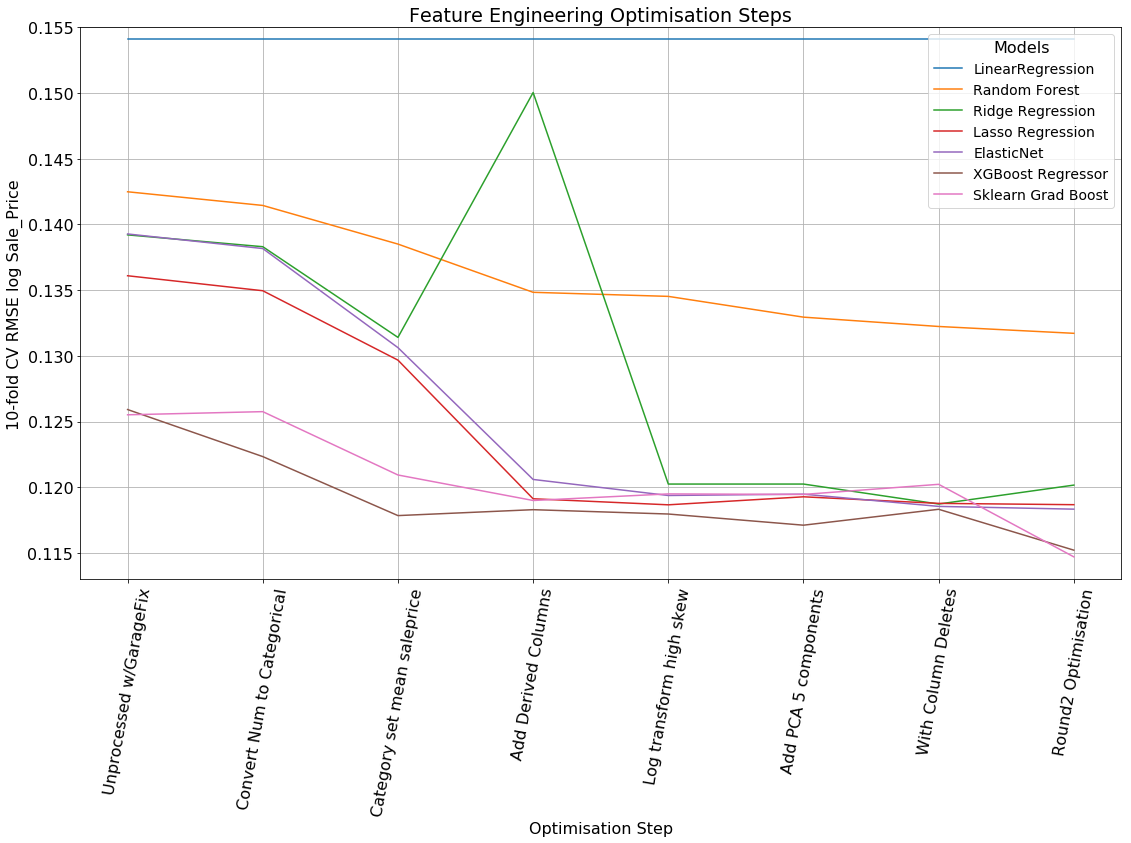

In [449]:
plt.rcParams.update({'font.size': 16})

results = pd.read_csv('results.csv', skiprows=9).transpose() 
results.columns = results.iloc[0]
results = results.iloc[1:-2, :-2].set_index('Model').astype(float)

fig, ax = plt.subplots(1,1,figsize=(16,6))
_ = results.plot.line(ax=ax, figsize=(16,12),  ylim=(0.113,0.155), title="Feature Engineering Optimisation Steps")
_ = ax.set_xticks(range(8))
_ = ax.set_xticklabels(results.index, rotation=80)
_ = ax.set_xlabel("Optimisation Step")
_ = ax.set_ylabel('10-fold CV RMSE log Sale_Price')
_ = plt.grid()
_ = plt.legend(loc='upper right', title='Models', prop={'size': 14} )
_ = plt.tight_layout()
_ = plt.savefig('Optimisation')

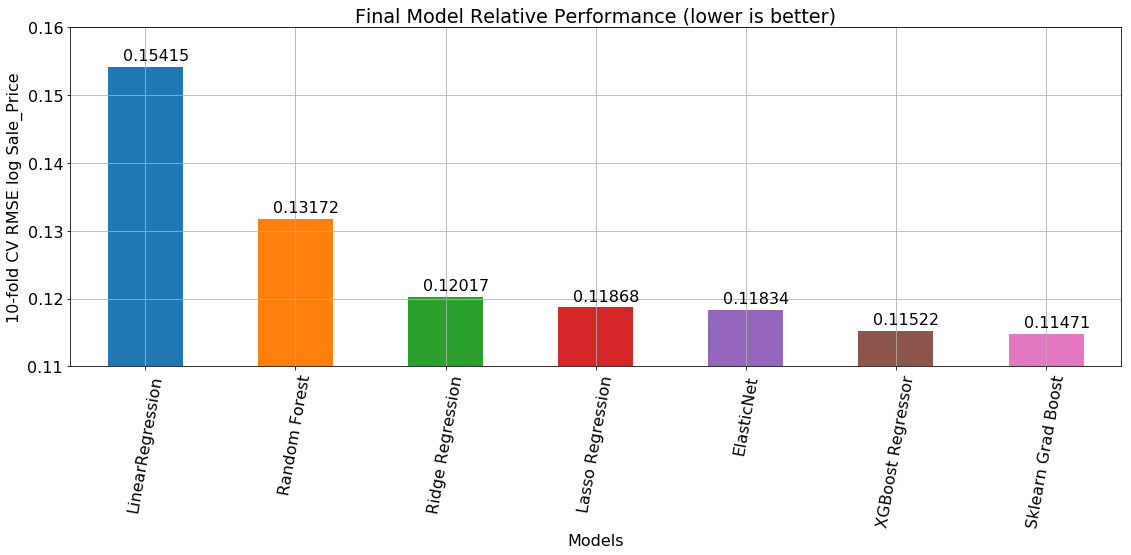

In [450]:
# Do bar chart
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1,1,figsize=(16,8))
temp = results.loc["Round2 Optimisation"].sort_values(ascending=False)
_ = temp.plot(kind='bar', ax=ax, ylim=(0.11,0.16), title="Final Model Relative Performance (lower is better)")
_ = ax.set_xticklabels(temp.index, rotation=80)
_ = ax.set_xlabel("Models")
_ = ax.set_ylabel('10-fold CV RMSE log Sale_Price')
_ = plt.grid()
for i, v in enumerate(temp):
    _ = ax.text(i-0.15, v+0.001 ,  str(v))
_ = plt.tight_layout()
_ = plt.savefig('Performance')

## Model Tuning (using Bayesian Optimisation with Gaussian Process)

In [ ]:
from skopt import gp_minimize
from skopt.plots import plot_convergence

def objective(values):    
    index = str(values)
    if index in cache:
        print('GET FROM CACHE:', index, round(cache[index],4))
        return cache[index]
    
    if model_type == 'Ridge':
        params = {'alpha': values[0],}
        model = Ridge(**params,)
    
    if model_type == 'Lasso':
        params = {'alpha': values[0],}
        model = Lasso(**params,)
        
    if model_type == 'RandomForestRegressor':
        params = {'n_estimators': values[0], 'max_features': values[1], 'max_depth': values[2],}
        model = RandomForestRegressor(**params, n_jobs=-1)
    
    if model_type == 'GradientBoostingRegressor':
        params = {'learning_rate': values[0], 'n_estimators': values[1], 'max_depth': values[2],
                  'min_samples_split': values[3], 'min_samples_leaf': values[4], 
                  'min_weight_fraction_leaf' : values[5], 'subsample': values[6], 'max_features': values[7] }
        model = GradientBoostingRegressor(**params, random_state=seed)
        
    if model_type == 'ElasticNet':
        params = {'alpha': values[0], 'l1_ratio': values[1],}
        model = ElasticNet(**params, max_iter=5000, tol=0.0001, random_state=seed)
    
    if model_type == 'XGBRegressor':
        params = {'learning_rate': values[0], 'n_estimators': int(values[1]), 'min_child_weight': int(values[2]),
                  'max_depth': int(values[3]), 'gamma': values[4], 'subsample': values[5],
                  'colsample_bytree': values[6], 'lambda': values[7], 'alpha': values[8], 'eval_metric':'rmse'}
        model = xgb.XGBRegressor(**params, random_state=seed, nthread=-1, n_jobs=-1,silent=1)
        
    print(datetime.datetime.now().time(), ', Params',params) 
    scores = -cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=10, n_jobs=10)
    cache[index] = np.sqrt (np.mean(scores) )
    return cache[index]

In [ ]:
%%time
np.random.seed(seed)
warnings.filterwarnings("ignore", category=UserWarning) # turn off already evaluated errors
params={'Ridge': [(1, 500),],
        'Lasso': [(0.0004, 0.06),],
#         'RandomForestRegressor': [  # Commented out as performance was much worse than ALL others
#                 (10, 600),            # n_estimators
#                 ['auto', 'sqrt'],      # max_features
#                 [None, 1,  5, 10, 20], # max_depth
#                 ],
        'GradientBoostingRegressor': [ 
                (0.01, 0.09),                            # learning rate
                (400, 1200),                             # n_estimators
                (3,4,5,6),                              # max_depth   
                (2,3,4,5,6),                            # min_samples_split 
                (2,3,4),                               # min_samples_leaf 
                (0,0.5),                                   # min_weight_fraction_leaf 
                (0.7,1.0),                              # subsample 
                ('auto', 'sqrt'),                       # max_features 
                ],
        'ElasticNet': [ 
                (0.001, 0.1),   # alpha
                (0.005, 0.5),    # l1_ratio
                ],
        'XGBRegressor': [
                (0.01, 0.09),                            # learning_rate 0.05, 0.3,
                (600, 1200),                            # n_estimators
                (3,4,5,6,7),                       # min_child_weight 
                (2,3,4,5,6),                          # max_depth 3-10
                (0,0.1),                                   # gamma 0-0.4
                (0.5,1.0),                              # subsample 0.5 - 0.99
                (0.5,1.0),                              # colsample_bytree 0.5 - 0.99
                (0.3,1.0),                               # reg_lambda
                (0.0,0.4),                              # reg_alpha
                ],}

model_types = params.keys()
model_types = ['GradientBoostingRegressor']
for model_type in model_types:
    cache = {}
    space = params[model_type]
    result = gp_minimize(objective, space, n_random_starts=2, n_calls=4, random_state=seed, verbose=True)
    
    print(model_type)
    print('Best Params=', result.x)
    print('Best Score=', round(result.fun,6))
    _ = plt.figure(figsize=(16,10))
    _ = plot_convergence(result, yscale='log')

warnings.filterwarnings("default", category=UserWarning) # turn on already evaluated errors

## XGBoost model hyperparameter search - CV and RandomSearch

In [ ]:
%%time
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error

params = {
      'learning_rate':    np.linspace(0.1, 1, 1), # 0.03 to 0.2, tuned to 0.75
      'min_child_weight': np.linspace(1, 9, 9, dtype=int),  # 1 to 6, tuned to 6
      'max_depth':        np.linspace(2, 10, 9, dtype=int), # 3 to 10, tuned to 3
      'gamma':            np.linspace(0, 0.4, 1), # 0 to 0.4, tuned to 0
      'subsample':        np.linspace(0.95, 1, 1),   # 0.6 to 1, tuned to 1.0
      'colsample_bytree': np.linspace(0.95, 1, 1), # 0.6 to 1, tuned to 0.6
      'reg_lambda':       np.linspace(1, 1, 1),   # 0 to 1, tuned to 1.0
      'reg_alpha':        np.linspace(0, 1, 1),  # 0 to 1, tuned to 0.5
      'silent':           [1,],
}
params

cv_params = {
      'learning_rate':    0.075,
      'min_child_weight': 6,
      'max_depth':        3,
      'gamma':            0,
      'subsample':        1,
      'colsample_bytree': 0.6,
      'reg_lambda':       1.0,
      'reg_alpha':        0.5,
      'silent':           1,
}

tune_cv=False #     perform CV just to get number of boost rounds/estimators before using GridSearchCV
if tune_cv:
    xgtrain = xgb.DMatrix(X_train, label=y_train)
    cvresult = xgb.cv(cv_params, xgtrain, num_boost_round=9000, early_stopping_rounds=50, nfold=10,
                verbose_eval=10, show_stdv=False)
else:
    XGBbase = xgb.XGBRegressor(base_score=np.mean(y_train), n_estimators=550, eval_metric='rmse', 
                               random_state=1, n_jobs=-1)
    XGBmodel = GridSearchCV(XGBbase, cv=10, n_jobs=-1, param_grid=params,scoring='neg_mean_squared_error',verbose=5)
    _ = XGBmodel.fit(X_train, y_train)
    print(XGBmodel.best_estimator_)
    print(XGBmodel.best_params_)
    print(-round(XGBmodel.best_score_,6))
    
# fig, ax = plt.subplots(1,1,figsize=(16,26))
# _ = xgb.plot_importance(model, ax=ax)

## Create Two Predictions  files from test.csv

In [ ]:
np.random.seed(seed)

# TRAIN LASSO MODEL AND GENERATE SUBMISSION FILE
model = ElasticNet(alpha=0.001, l1_ratio=0.4, max_iter=5000, tol=0.0001, random_state=seed),
_ = model.fit(X_train, y_train)
XGBpreds = model.predict(X_test)
XGB_df = pd.DataFrame({'PID': y_test.index, 'Sale_Price': np.expm1(XGBpreds).round(1)})
XGB_df.to_csv('mysubmission1.txt', index=False)
print('Created mysubmission1.txt, rows=', XGB_df.shape[0], 
      ', Model=', type(model).__name__, ', RMSElogPrice =', round( rmse(y_test, XGBpreds),6 ))

# TRAIN GBM MODEL AND GENERATE SUBMISSION FILE
model = GradientBoostingRegressor(learning_rate=0.03, n_estimators=550, max_depth=5, min_samples_split=4,
            min_samples_leaf=3, min_weight_fraction_leaf=0, subsample=0.64, max_features='sqrt', random_state=seed)
_ = model.fit(X_train, y_train)
ENet_preds = model.predict(X_test)
ENet_df = pd.DataFrame({'PID': y_test.index, 'Sale_Price': np.expm1(ENet_preds).round(1)})
ENet_df.to_csv('mysubmission2.txt', index=False)
print('Created mysubmission2.txt, rows=', XGB_df.shape[0], 
      ', Model=', type(model).__name__, ', RMSElogPrice =', round( rmse(y_test, ENet_preds),6 ))

# RE-READ SUBMISSION FILES AND CHECK FOR CORRECTNESS
temp = pd.read_csv('mysubmission1.txt')
print('\nChecking mysubmission1 file, RMSE=', round(rmse(np.log1p(temp.Sale_Price), y_test.values),6) )
temp = pd.read_csv('mysubmission2.txt')
print('Checking mysubmission2 file, RMSE=', round(rmse(np.log1p(temp.Sale_Price), y_test.values),6) )


## Extreme Value Analysis

In [ ]:
col = 'Sale_Price'
trainO[col].max()
trainO[col].quantile(q=0.999)
_ = plt.figure(figsize=(16,8))
_ = trainO[col].hist(bins=50)

In [ ]:
warnings.filterwarnings("ignore", category=RuntimeWarning) 
fig, ax = plt.subplots(6,7, figsize=(16,30))
x = 0; y = 0;
for col in trainO.select_dtypes(exclude=["object"]).columns:
    _ = ax[y,x].boxplot(trainO[col])
    _ = ax[y,x].set_title(col)
    x+=1
    if x >= 7:
        x=0; y+=1
_ = plt.tight_layout()
warnings.filterwarnings("default", category=RuntimeWarning) 

In [ ]:
import matplotlib.pyplot as plt
_ = pd.Series(rmses).hist( bins = 30)
_ = plt.axvline(x=np.mean(gbm), color='black')
_ = plt.axvline(x=0.12,  color='yellow')
_ = plt.axvline(x=0.132, color='red')